#交通流最適化問題
QUBOをつかった組合せ最適化問題で社会問題を解く試みも広く進んでいます。ここでは、道路の混雑状況を組合せ最適化問題を利用して解消する計算について見ていきたいと思います。


##参考資料
今回は独VW社のpaperを参考にします。

「Quantum Computing at Volkswagen:  
Traffic Flow Optimization using the D-Wave Quantum Annealer」  
引用：https://www.dwavesys.com/sites/default/files/VW.pdf



参考仕様による、解法は下記の通りです。  
既存計算機を「古典計算機」と表現しています。  

Classical: Pre-process map and GPS data.  
（古典計算機）地図とGPSデータからデータの準備をする。  

Classical: Identify areas where traffic congestion occurs.  
（古典計算機）次に混雑が起こっている場所を特定する。  


Classical: Determine spatially and temporally valid alternative routes for each car in the dataset, if possible.  
（古典計算機）データセット内の自動車に対して代替ルートを提案する  


Classical: Formulate the minimization problem as a QUBO (to minimize congestion in road segments on overlapping routes).  
（古典計算機）混雑が緩和するような組合せ最適化問題に落とし込む。その際のQUBOと呼ばれる形式を採用する。  


Hybrid Quantum/Classical: Find a solution that reduces congestion among route assignments　in the whole traffic graph.  
（古典計算機・量子コンピュータハイブリッド）問題を古典計算機による分割と量子コンピュータによる最適化を繰り返す。  


Classical: Redistribute the cars based on the results.  
（古典計算機）上記の得られた答えから自動車の位置を再配置する。  


Iterate over steps 2 to 6 until no traffic congestion is identified.  
上記のステップを混雑が緩和されるまで繰り返し計算する。  


引用：https://arxiv.org/pdf/1708.01625.pdf


基本的にはQUBO計算だけでなく、たくさんの前処理が出ます。


##例題
簡単な例題を解いて見たいと思います。

9ノード12エッジの道路を考えます。模擬的に羽田空港から国立競技場までのルートを考えてみます。

<img src="https://github.com/Blueqat/Wildqat/blob/master/examples_ja/img/017_1.png?raw=1">

##自動車の配置を考える
想定するモデルができたらまず自動車を配置します。

自動車は4台程度にして見ます。
配置はいい感じに入れて見ます。セグメント道路に入れて見て、実際の後ほど行う代替ルート提案は近隣の交差点からやります。せっかくなので、２台はスタート地点から、のこり２台はそれぞれの途中地点に入れて見ます。

こんな感じです。

<img src="https://github.com/Blueqat/Wildqat/blob/master/examples_ja/img/017_2.png?raw=1">




##各自動車に対して目的地までのルート提案３ルートずつをつくる
各自動車に対して取りうるルートを３つずつ提案し、そのうちの１つを採用していることにします。
自動車#1と自動車#2はスタート地点からで同じルートを選んでいることにします。
自動車#3と自動車#4についても提案ルートを作ります。

これらの関係性をエクセルで作って見ました。

<img src="https://github.com/Blueqat/Wildqat/blob/master/examples_ja/img/017_3.png?raw=1">

図で表すとこのような感じです。

<img src="https://github.com/Blueqat/Wildqat/blob/master/examples_ja/img/017_4.png?raw=1">

##道路混雑を計算する
道路混雑状況はこの自動車の配置から割り出します。先ほどの経路提案からその中に含まれるセグメントの道路の数を全て道路ごとにカウントします。その際に出てきた道路を経路提案の表記で表します（Q11とか）。こちらもとりあえずエクセルでやって見ました。

混雑状況は提案ルート内に道路が含まれているかによって決まり、カウントしたコストの２乗を盛り込みます。

<img src="https://github.com/Blueqat/Wildqat/blob/master/examples_ja/img/017_5.png?raw=1">

トータルの混雑状況はコスト29と出ています。このコストを量子コンピュータによって下げて混雑解消します。

##混雑計算の一般式をQUBOでつくる
QUBOとはバイナリの値{0,1}をつかって、コスト関数と呼ばれる数式を作ります。今回コスト関数を作る上で必要になるのは、

１、混雑量を計算するコスト関数
２、自動車１台について代替ルート提案を１ルートだけ選ぶ制約条件

の２つになります。まず前者からやってみます。交通混雑のコストは前述の各セグメントの混雑を全て足し合わせたものです。一般的な表記を残したまま、全てを足して見ます。

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%20(Q_%7B11%7D%2BQ_%7B12%7D%2BQ_%7B21%7D%2BQ_%7B22%7D)%5E2%20%2B%20(Q_%7B12%7D%2BQ_%7B22%7D%2BQ_%7B43%7D)%5E2%20%2B%20(Q_%7B13%7D%2BQ_%7B23%7D)%5E2%20%2B%20(Q_%7B11%7D%2BQ_%7B21%7D%2BQ_%7B43%7D)%5E2%0D%0A%2B%20(Q_%7B12%7D%2BQ_%7B22%7D%2BQ_%7B43%7D)%5E2%20%2B%20(Q_%7B13%7D%2BQ_%7B23%7D%2BQ_%7B32%7D%2BQ_%7B33%7D)%5E2%20%2B%20(Q_%7B11%7D%2BQ_%7B21%7D%2BQ_%7B33%7D%2BQ_%7B41%7D)%5E2%20%2B%20Q_%7B31%7D%5E2%0D%0A%2B%20(Q_%7B13%7D%2BQ_%7B23%7D%2BQ_%7B32%7D%2BQ_%7B42%7D)%5E2%20%2B%20(Q_%7B11%7D%2BQ_%7B12%7D%2BQ_%7B21%7D%2BQ_%7B22%7D%2BQ_%7B33%7D%2BQ_%7B41%7D%2BQ_%7B43%7D)%5E2%20%2B%20Q_%7B31%7D%5E2%0D%0A%2B%20(Q_%7B13%7D%2BQ_%7B23%7D%2BQ_%7B31%7D%2BQ_%7B32%7D%2BQ_%7B42%7D)%5E2">

つぎにこれをすべて展開します。展開した式は、

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%204Q_%7B11%7D%5E2%20%2B%204Q_%7B11%7DQ_%7B12%7D%20%2B%208Q_%7B11%7DQ_%7B21%7D%20%2B%204Q_%7B11%7DQ_%7B22%7D%20%2B%204Q_%7B11%7DQ_%7B33%7D%20%2B%204Q_%7B11%7DQ_%7B41%7D%20%2B%204Q_%7B11%7DQ_%7B43%7D%20%2B%204Q_%7B12%7D%5E2%20%2B%204Q_%7B12%7DQ_%7B21%7D%20%2B%208Q_%7B12%7DQ_%7B22%7D%20%2B%202Q_%7B12%7DQ_%7B33%7D%20%2B%202Q_%7B12%7DQ_%7B41%7D%20%2B%206Q_%7B12%7DQ_%7B43%7D%20%2B%204Q_%7B13%7D%5E2%20%2B%208Q_%7B13%7DQ_%7B23%7D%20%2B%202Q_%7B13%7DQ_%7B31%7D%20%2B%206Q_%7B13%7DQ_%7B32%7D%20%2B%202Q_%7B13%7DQ_%7B33%7D%20%2B%204Q_%7B13%7DQ_%7B42%7D%20%2B%204Q_%7B21%7D%5E2%20%2B%204Q_%7B21%7DQ_%7B22%7D%20%2B%204Q_%7B21%7DQ_%7B33%7D%20%2B%204Q_%7B21%7DQ_%7B41%7D%20%2B%204Q_%7B21%7DQ_%7B43%7D%20%2B%204Q_%7B22%7D%5E2%20%2B%202Q_%7B22%7DQ_%7B33%7D%20%2B%202Q_%7B22%7DQ_%7B41%7D%20%2B%206Q_%7B22%7DQ_%7B43%7D%20%2B%204Q_%7B23%7D%5E2%20%2B%202Q_%7B23%7DQ_%7B31%7D%20%2B%206Q_%7B23%7DQ_%7B32%7D%20%2B%202Q_%7B23%7DQ_%7B33%7D%20%2B%204Q_%7B23%7DQ_%7B42%7D%20%2B%203Q_%7B31%7D%5E2%20%2B%202Q_%7B31%7DQ_%7B32%7D%20%2B%202Q_%7B31%7DQ_%7B42%7D%20%2B%203Q_%7B32%7D%5E2%20%2B%202Q_%7B32%7DQ_%7B33%7D%20%2B%204Q_%7B32%7DQ_%7B42%7D%20%2B%203Q_%7B33%7D%5E2%20%2B%204Q_%7B33%7DQ_%7B41%7D%20%2B%202Q_%7B33%7DQ_%7B43%7D%20%2B%202Q_%7B41%7D%5E2%20%2B%202Q_%7B41%7DQ_%7B43%7D%20%2B%202Q_%7B42%7D%5E2%20%2B%204Q_%7B43%7D%5E2%0D%0A">

長すぎるので簡単のために各項の係数をQUBOmatrixと呼ばれる行列に落とし込みます。12*12の行列を使います。

<img src="https://github.com/Blueqat/Wildqat/blob/master/examples_ja/img/017_6.png?raw=1">

今回は一旦これをlistとしてpythonで用意しておきます。

In [1]:
!pip install blueqat

     |████████████████████████████████| 51kB 2.0MB/s 


In [0]:
import blueqat.opt as wq
import numpy as np
a = wq.opt()
a.qubo = [
    [4,4,0,8,4,0,0,0,4,4,0,4],
    [0,4,0,4,8,0,0,0,2,2,0,6],
    [0,0,4,0,0,8,2,6,2,0,4,0],
    [0,0,0,4,4,0,0,0,4,4,0,4],
    [0,0,0,0,4,0,0,0,2,2,0,6],
    [0,0,0,0,0,4,2,6,2,0,4,0],
    [0,0,0,0,0,0,3,2,0,0,4,0],
    [0,0,0,0,0,0,0,3,2,0,4,0],
    [0,0,0,0,0,0,0,0,3,4,0,2],
    [0,0,0,0,0,0,0,0,0,2,0,2],
    [0,0,0,0,0,0,0,0,0,0,2,0],
    [0,0,0,0,0,0,0,0,0,0,0,4]
]

##制約条件をつける
一台の車ごとに制約条件は１つのルートをとるという条件をつけます。

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%20K*(Q_%7B11%7D%2BQ_%7B12%7D%2BQ_%7B13%7D-1)%5E2%2BK*(Q_%7B21%7D%2BQ_%7B22%7D%2BQ_%7B23%7D-1)%5E2%2BK*(Q_%7B31%7D%2BQ_%7B32%7D%2BQ_%7B33%7D-1)%5E2%2BK*(Q_%7B41%7D%2BQ_%7B42%7D%2BQ_%7B43%7D-1)%5E2">

展開すると、

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%20KQ_%7B11%7D%5E2%20%2B%202KQ_%7B11%7DQ_%7B12%7D%20%2B%202KQ_%7B11%7DQ_%7B13%7D%20-%202KQ_%7B11%7D%20%2B%20KQ_%7B12%7D%5E2%20%2B%202KQ_%7B12%7DQ_%7B13%7D%20-%202KQ_%7B12%7D%20%2B%20KQ_%7B13%7D%5E2%20-%202KQ_%7B13%7D%20%2B%20KQ_%7B21%7D%5E2%20%2B%202KQ_%7B21%7DQ_%7B22%7D%20%2B%202KQ_%7B21%7DQ_%7B23%7D%20-%202KQ_%7B21%7D%20%2B%20KQ_%7B22%7D%5E2%20%2B%202KQ_%7B22%7DQ_%7B23%7D%20-%202KQ_%7B22%7D%20%2B%20KQ_%7B23%7D%5E2%20-%202KQ_%7B23%7D%20%2B%20KQ_%7B31%7D%5E2%20%2B%202KQ_%7B31%7DQ_%7B32%7D%20%2B%202KQ_%7B31%7DQ_%7B33%7D%20-%202KQ_%7B31%7D%20%2B%20KQ_%7B32%7D%5E2%20%2B%202KQ_%7B32%7DQ_%7B33%7D%20-%202KQ_%7B32%7D%20%2B%20KQ_%7B33%7D%5E2%20-%202KQ_%7B33%7D%20%2B%20KQ_%7B41%7D%5E2%20%2B%202KQ_%7B41%7DQ_%7B42%7D%20%2B%202KQ_%7B41%7DQ_%7B43%7D%20-%202KQ_%7B41%7D%20%2B%20KQ_%7B42%7D%5E2%20%2B%202KQ_%7B42%7DQ_%7B43%7D%20-%202KQ_%7B42%7D%20%2B%20KQ_%7B43%7D%5E2%20-%202KQ_%7B43%7D%20%2B%204K">

こちらも見にくいので、QUBOmatrixの形にします。

<img src="https://github.com/Blueqat/Wildqat/blob/master/examples_ja/img/017_7.jpeg?raw=1">

これもwildqatにいれてみます。

In [3]:
k = 10
kk = np.diag([-k for i in range(12)])

for i in range(0,12,3):
  kk[i][i+1] = 2*k
  kk[i][i+2] = 2*k
  kk[i+1][i+2] = 2*k

print(kk)

a.qubo += kk
print(a.qubo)
a.sa()

[[-10  20  20   0   0   0   0   0   0   0   0   0]
 [  0 -10  20   0   0   0   0   0   0   0   0   0]
 [  0   0 -10   0   0   0   0   0   0   0   0   0]
 [  0   0   0 -10  20  20   0   0   0   0   0   0]
 [  0   0   0   0 -10  20   0   0   0   0   0   0]
 [  0   0   0   0   0 -10   0   0   0   0   0   0]
 [  0   0   0   0   0   0 -10  20  20   0   0   0]
 [  0   0   0   0   0   0   0 -10  20   0   0   0]
 [  0   0   0   0   0   0   0   0 -10   0   0   0]
 [  0   0   0   0   0   0   0   0   0 -10  20  20]
 [  0   0   0   0   0   0   0   0   0   0 -10  20]
 [  0   0   0   0   0   0   0   0   0   0   0 -10]]
[[-6 24 20  8  4  0  0  0  4  4  0  4]
 [ 0 -6 20  4  8  0  0  0  2  2  0  6]
 [ 0  0 -6  0  0  8  2  6  2  0  4  0]
 [ 0  0  0 -6 24 20  0  0  4  4  0  4]
 [ 0  0  0  0 -6 20  0  0  2  2  0  6]
 [ 0  0  0  0  0 -6  2  6  2  0  4  0]
 [ 0  0  0  0  0  0 -7 22 20  0  4  0]
 [ 0  0  0  0  0  0  0 -7 22  0  4  0]
 [ 0  0  0  0  0  0  0  0 -7  4  0  2]
 [ 0  0  0  0  0  0  0  0  0 -8 20 2

[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]

上記のようになりました。
きちんと１台につき、１ルートが割り当てられています。
最終のコストも確認しておきます。

In [4]:
print(a.E[-1])

-23.0


コスト推移はmatplotlibで確認することができます。

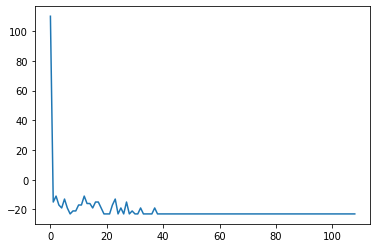

In [5]:
a.plot()